# PINN: Heat equation with variable diffusion
Solving the heat equation in 2D for variable diffusion D using the PINN-concept.

This is the same example as in the folder examples/pinn, but in the second part of the notebook, the problem is solved in Modulus with the wrapper module of TorchPhysics.

In [1]:
import torch
import torchphysics as tp
import pytorch_lightning as pl
import math

First, we create the spaces for our problem. These define the variable names which will be used in the remaining part of this code.

In this example, x is the space variable, t corresponds to the time, D is an interval of diffusions and u is the variable for the (1D-)solution.

In [2]:
X = tp.spaces.R2('x')
T = tp.spaces.R1('t')
D = tp.spaces.R1('D')

U = tp.spaces.R1('u')

As a next step, we build the domain of the problem. There are multiple options to build multi-dimensional domains - in this case, we simply create a rectangle in space and intervals in time and diffusion which will later be multiplied to obtain the cartesian product.

In [3]:
h, w = 20, 20

In [4]:
A_x = tp.domains.Parallelogram(X, [0, 0], [w, 0], [0, h])
A_t = tp.domains.Interval(T, 0, 40)
A_D = tp.domains.Interval(D, 0.1, 1.0)

Before we visualize the created domain, we create Sampler objects which are iterators that sample points from the domain during the optimization task. There are again various options to sample from the domains, an easy way would be to sample uniformly distributed random points. In this example, we choose an adaptive sampler to sample points in the inner of the domain. It will sample more points in points where the loss is large.

The amount of sampled points is defined by their density in the 3/2-dim subset, it could be increased to achieve better training results.

In [5]:
inner_sampler = tp.samplers.AdaptiveRandomRejectionSampler(A_x*A_t*A_D, density=1)
# initial values should be sampled on the left boundary of the time interval and for every x and D
initial_v_sampler = tp.samplers.RandomUniformSampler(A_x*A_t.boundary_left*A_D, density=1)

boundary_v_sampler = tp.samplers.RandomUniformSampler(A_x.boundary*A_t*A_D, density=1)

We visualize the domain through the points created by the samplers using matplotlib:

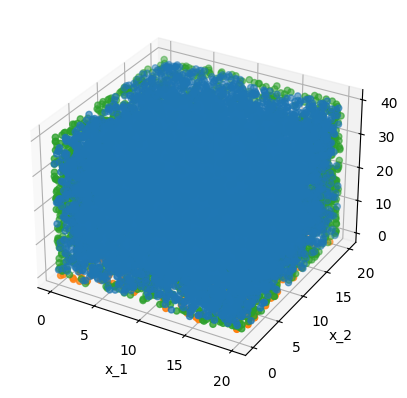

In [6]:
fig = tp.utils.scatter(X*T, inner_sampler, initial_v_sampler, boundary_v_sampler)

In the next step we define the NN-model we want to fit to the PDE. A normalization can improve convergence for large or small domains.

In [7]:
model = tp.models.Sequential(
    tp.models.NormalizationLayer(A_x*A_t*A_D),
    tp.models.FCN(input_space=X*T*D, output_space=U, hidden=(50,50,50))
)

Now, we define a condition which aims to minimze the mean squared error of the residual of the poisson equation. 

In [8]:
def heat_residual(u, x, t, D):
    return D*tp.utils.laplacian(u, x) - tp.utils.grad(u, t)

pde_condition = tp.conditions.PINNCondition(module=model,
                                            sampler=inner_sampler,
                                            residual_fn=heat_residual,
                                            name='pde_condition')

Additionally, we add a boundary condition at the boundary of the domain:

In [9]:
def boundary_v_residual(u):
    return u

boundary_v_condition = tp.conditions.PINNCondition(module=model,
                                                     sampler=boundary_v_sampler,
                                                     residual_fn=boundary_v_residual,
                                                     name='boundary_condition')

The initial condition can be defined via a data function. Again, we minimize the mean squared error over the sampled points.

In [10]:
def f(x):
    return torch.sin(math.pi/w*x[:, :1])*torch.sin(math.pi/h*x[:,1:])

def initial_v_residual(u, f):
    return u-f

initial_v_condition = tp.conditions.PINNCondition(module=model,
                                                  sampler=initial_v_sampler,
                                                  residual_fn=initial_v_residual,
                                                  data_functions={'f': f},
                                                  name='initial_condition')

For comparison, we compute the solution via a finite difference scheme.

In [11]:
import sys
sys.path.append('..')

from fdm_heat_equation import FDM, transform_to_points

fdm_domain, fdm_time_domains, fdm_solution = FDM([0, w, 0, h], 2*[2e-1], [0,5], [0.1,0.2,0.4,0.6,0.8, 1.0], f)
fdm_inp, fdm_out = transform_to_points(fdm_domain, fdm_time_domains, fdm_solution, [0.1,0.2,0.4,0.6,0.8, 1.0], True)

Comparsion to measured or computed data can be performed via a DataCondition using data supplied via a PointsDataLoader.

In [12]:
val_condition = tp.conditions.DataCondition(module=model,
                                            dataloader=tp.utils.PointsDataLoader((fdm_inp, fdm_out), batch_size=80000),
                                            norm='inf')

# 1. Training in TorchPhysics

Finally, we optimize the conditions using a pytorch-lightning.LightningModule Solver and running the training. In the Solver, the training and validation conditions, as well as all optimizer options can be specified.

The process of the training can be monitored with Tensorboard (e.g. tensorboard --logdir=lightning_logs --port=0). The losses are plotted under the tab "SCALARS" and the plots of the PlotterCallback can be found in the tab "IMAGES".

In [13]:
decay_rate = 0.95
decay_steps = 15000
optim_setting = tp.solver.OptimizerSetting(torch.optim.Adam, lr=0.001,
                            scheduler_class=torch.optim.lr_scheduler.ExponentialLR,
                            scheduler_args={"gamma": decay_rate ** (1.0 / decay_steps)})

solver = tp.solver.Solver([pde_condition,
                           boundary_v_condition,
                           initial_v_condition], [val_condition],
                           optimizer_setting=optim_setting)

run_name ='Heat_equation_paramD'

plot_sampler = tp.samplers.PlotSampler(plot_domain=A_x, n_points=1000,device='cpu', data_for_other_variables={'D':1.0, 't': 5})
callbacks = [  tp.utils.PlotterCallback(model=model,plot_function=lambda u: u[:,0],point_sampler=plot_sampler, 
                                         plot_type='contour_surface',log_name=run_name, check_interval=50),                 
                
                pl.callbacks.LearningRateMonitor(logging_interval='step')
            ]



trainer = pl.Trainer(devices=1, accelerator="gpu",
                     max_steps = 200,                     
                     benchmark=True,            
                     val_check_interval=40,
                     enable_checkpointing=False,
                     callbacks = callbacks
                    )

trainer.fit(solver)



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/gea3si/.conda/envs/mod_tp/lib/python3.10/site-packages/pytorch_lightning/core/optimizer.py:258: Found unsupported keys in the lr scheduler dict: {'gamma'}. HINT: remove them from the output of `configure_optimizers`.

  | Name             | Type       | Params | Mode 
--------------------------------------------------------
0 | train_conditions | ModuleList | 5.4 K  | train
1 | val_conditions   | ModuleList | 5.4 K  | train
--------------------------------------------------------
5.4 K     Trainable params
0         Non-trainable params
5.4 K     Total params
0.022     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/gea3si/.conda/envs/mod_tp/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.


Finally, we plot the obtained solution:

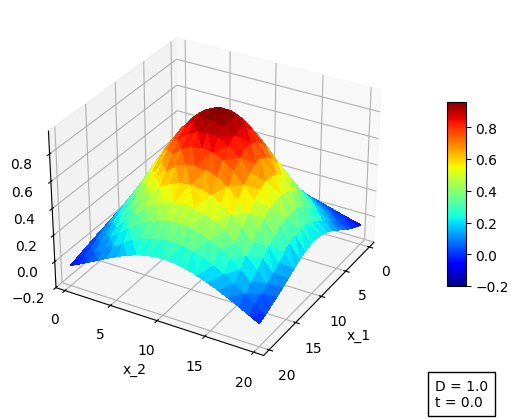

In [14]:
anim_sampler = tp.samplers.AnimationSampler(A_x, A_t, 100, n_points=400, data_for_other_variables={'D': 1.0})
anim = tp.utils.animate(model, lambda u: u[:, 0], anim_sampler, ani_speed=10)
anim[1].save('heat-eq.gif')

# 2. Training with the wrapper in Modulus

Now, we want to do the training in Modulus with the usage of the TPModulusWrapper.

Remember that an additional Modulus installation is required!


We use a Modulus Fourier net architecture with the ModulusArchitectureWrapper.

In [15]:
model = tp.models.Sequential(
    tp.models.NormalizationLayer(A_x*A_t*A_D),    
    tp.wrapper.ModulusArchitectureWrapper(input_space=X*T*D, output_space=U, arch_name='fourier', frequencies = ['axis',[0,1,2]])
)

/home/gea3si/.conda/envs/mod_tp/lib/python3.10/site-packages/modulus/sym/hydra/utils.py:150: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(


New initialization of the same conditions as before.

Since Modulus by default saves the resulting values of the condition objectives and validation in VTK-files, the training procedure will slow down, when the amount of validation data increase or if the frequency of validation (val_check_interval) or the plotter callback frequency (check_interval) is too high.

In [16]:
pde_condition = tp.conditions.PINNCondition(module=model,
                                            sampler=inner_sampler,
                                            residual_fn=heat_residual,
                                            name='pde_condition')
boundary_v_condition = tp.conditions.PINNCondition(module=model,
                                                     sampler=boundary_v_sampler,
                                                     residual_fn=boundary_v_residual,
                                                     name='boundary_condition')
initial_v_condition = tp.conditions.PINNCondition(module=model,
                                                  sampler=initial_v_sampler,
                                                  residual_fn=initial_v_residual,
                                                  data_functions={'f': f},
                                                  name='initial_condition')
val_condition = tp.conditions.DataCondition(module=model,
                                            dataloader=tp.utils.PointsDataLoader((fdm_inp, fdm_out), batch_size=80000),
                                            norm='inf')

The learning rate monitor callback could be omitted here, as Modulus uses it by default.

The process of the training can be monitored again with tensorboard, but in this example with --logdir=outputs_heat, as this is the name of the folder containing the Modulus output.


In [17]:
decay_rate = 0.95
decay_steps = 15000
optim_setting = tp.solver.OptimizerSetting(torch.optim.Adam, lr=0.001,
                            scheduler_class=torch.optim.lr_scheduler.ExponentialLR,
                            scheduler_args={"gamma": decay_rate ** (1.0 / decay_steps)})

solver = tp.solver.Solver([pde_condition,
                           boundary_v_condition,
                           initial_v_condition], 
                          [val_condition],
                           optimizer_setting=optim_setting)

run_name ='Heat_equation_paramD_Modulus'

plot_sampler = tp.samplers.PlotSampler(plot_domain=A_x, n_points=1000,device='cpu', data_for_other_variables={'D':1.0, 't': 5})
callbacks = [  tp.utils.PlotterCallback(model=model,plot_function=lambda u: u[:,0],point_sampler=plot_sampler, 
                                         plot_type='contour_surface',log_name=run_name, check_interval=50),                 
                
                pl.callbacks.LearningRateMonitor(logging_interval='step')
            ]



trainer = pl.Trainer(devices=1, accelerator="gpu",
                     max_steps = 200,                     
                     benchmark=True,            
                     val_check_interval=40,
                     enable_checkpointing=False,
                     callbacks = callbacks
                    )


tp.wrapper.TPModulusWrapper(trainer,solver,confdir_name='conf_heat',outputdir_name='outputs_heat').train()



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/gea3si/.conda/envs/mod_tp/lib/python3.10/site-packages/modulus/sym/hydra/utils.py:150: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(
Setting JobRuntime:name=app
/home/gea3si/NewModTpWrapper/torchphysics/src/torchphysics/wrapper/solver.py:168: UserWarning: Modulus only supports RandomUniformSampler or Halton sequence. Using RandomUniformSampler instead.
  warnings.warn("Modulus only supports RandomUniformSampler or Halton sequence. Using RandomUniformSampler instead.")
/home/gea3si/.conda/envs/mod_tp/lib/python3.10/site-packages/modulus/sym/trainer.py:453: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = GradScaler(enabled=enable_scaler)
attempting to restore from: /home/gea3si/NewModTpWrapper/torchphysics/examples/wrapper/outputs_heat
optimizer checkpoint not found

[]

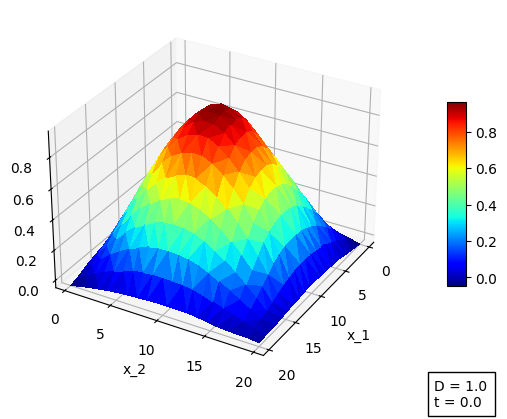

In [18]:
anim_sampler = tp.samplers.AnimationSampler(A_x, A_t, 100, n_points=400, data_for_other_variables={'D': 1.0})
anim = tp.utils.animate(model, lambda u: u[:, 0], anim_sampler, ani_speed=10)
anim[1].save('heat-eq-wrapper.gif')

There are addtional options for the training with the wrapper, e.g. use of aggregating function like LR Annealing or using spatial loss weighting, e.g. with the signed distance function. 
For further information use the help function

In [19]:
help(tp.wrapper.TPModulusWrapper)

Help on class TPModulusWrapper in module torchphysics.wrapper.wrapper:

class TPModulusWrapper(builtins.object)
 |  TPModulusWrapper(trainer, solver, outputdir_name='outputs', confdir_name='conf', keep_output=True, **kwargs)
 |  
 |  Training of a TorchPhysics trainer/solver with the Modulus wrapper.
 |  The wrapper is a bridge between TorchPhysics and Modulus. It uses
 |  the Modulus configuration and the Modulus solver to train the 
 |  TorchPhysics solver/trainer/models.
 |  Loss weighting algorithms can be selected by choosing an
 |  aggregation function. The aggregation function can be selected by
 |  the parameter "aggregator" and additional arguments can be set by 
 |  the parameter "aggregator_args".
 |  A learning rate scheduler can be selected by the parameter 
 |  "scheduler" and additional arguments can be set by the parameter 
 |  "scheduler_args".
 |  Pointwise weighting of the loss can be set by the parameter 
 |  "lambda_weighting". The pointwise weighting can be a list

Training with the use of LR Annealing and the sdf function for spatial weighting.

In [20]:
tp.wrapper.TPModulusWrapper(trainer,solver,lambda_weighting=["sdf"],aggregator='LRAnnealing',confdir_name='conf_heat',outputdir_name='outputs_heat').train()

/home/gea3si/.conda/envs/mod_tp/lib/python3.10/site-packages/modulus/sym/hydra/utils.py:150: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(
Setting JobRuntime:name=app


/home/gea3si/NewModTpWrapper/torchphysics/src/torchphysics/wrapper/solver.py:168: UserWarning: Modulus only supports RandomUniformSampler or Halton sequence. Using RandomUniformSampler instead.
  warnings.warn("Modulus only supports RandomUniformSampler or Halton sequence. Using RandomUniformSampler instead.")
/home/gea3si/.conda/envs/mod_tp/lib/python3.10/site-packages/modulus/sym/trainer.py:453: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = GradScaler(enabled=enable_scaler)
attempting to restore from: /home/gea3si/NewModTpWrapper/torchphysics/examples/wrapper/outputs_heat
optimizer checkpoint not found
model model0.0.pth not found
[step:          0] saved constraint results to outputs_heat
[step:          0] record constraint batch time:  1.811e-01s
[step:          0] saved validator results to outputs_heat
[step:          0] record validators time:  4.099e+01s
[step:          0] saved in

[]